In [1533]:
#import user modules
import helper_functions as hfun
import config as cf
import thouless_times as thouless
import importlib
importlib.reload(hfun)
importlib.reload(cf)
importlib.reload(thouless)

#--- importet in user module
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
import os
from utils import exit
from os import sep as kPSep
from os.path import exists

#--- other modules
import numpy as np
import itertools
import seaborn as sns
import pandas as pd
import math
import random
import imageio
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from scipy.optimize import curve_fit
from joblib import Parallel, delayed
import copy
#plt.style.use(['science','ieee','no-latex'])

# get all the colors
import matplotlib.colors as mcolors
from scipy.special import binom
import sympy as sym

print(cf.base_directory)


user_settings = getattr(cf.plot_settings, 'settings')

../results/Heisenberg/disorder/PBC/


In [1534]:

#--- SET SCALING RANGES AND DATA
x0 = 0.02
xend = 0.6
dx = 0.08
length = int((xend-x0) / dx) + 1

def get_scaling_array(settings = None):
    if settings == None:
        settings = user_settings
    vals = []
    if settings['scaling_idx'] == 0:
        if cf.hamiltonian: vals = range(12, 19, 2)
        else: vals = range(11, 17, 1)
    elif cf.model and settings['scaling_idx'] == 4:
        vals = range(0, cf.params_arr[0])
    else :
        for x in range(0, length) :
            vals.append(x0 + x * dx)
    return np.array(vals)

def plot_spectral(axis, dir = "", settings = None, xlab = None, ylab = None, yscale=None, xscale=None, func_x=None, func_y=None, normalise=False):
    #-- main settings
    if settings == None:
        settings = user_settings
    #-- labels
    if xlab == None: xlab = "x"
    if ylab == None: ylab = "x"
    #-- axis scales
    if xscale != None: settings['x_scale'] = xscale
    if yscale != None: settings['y_scale'] = yscale
    #-- axis rescaling
    if func_x == None: func_x = lambda x, a: x
    if func_y == None: func_y = lambda y, a: y
    param_copy = copy.deepcopy(cf.params_arr)

    #--- prepare scaling - axis
    vals = get_scaling_array(settings=settings)

    y_min = 1.0e10;     y_max = -1.0e10;
    x_min = 1.0e10;     x_max = -1.0e10;
    #--- load data and plot one-by-one
    wH = []
    LTA = []
    for x in vals:
        cf.params_arr[settings['scaling_idx']] = x
        if settings['scaling_idx'] == 3 and cf.J0 == 0 and cf.g0 == 0:
            cf.params_arr[4] = int(100 * x / 2.) / 100.
        filename = dir + cf.op_name + hfun.info_param(cf.params_arr)
        if exists(filename):
            data = pd.read_table(filename, sep="\t", header=None)
            xdata = func_x(data[0], x)
            wHnow = func_x(data[2][0], x)
            ytmp = data[1]
            if normalise:
                ytmp = (ytmp - data[3][0]) / np.abs(ytmp[len(ytmp)-1] - ytmp[0])
            ydata = func_y(ytmp, x)
            wH.append(wHnow)
            idx = min(range(len(xdata)), key=lambda i: abs(xdata[i] - wHnow))
            LTA.append(ydata[idx])
            axis.plot(xdata, ydata, label=hfun.key_title(x, settings))
            
            #-- xy-ranges
            mini = ydata.min();  maxi = ydata.max();
            if mini < y_min and np.isfinite(mini): y_min = mini
            if maxi > y_max and np.isfinite(maxi): y_max = maxi
            mini = xdata.min();  maxi = xdata.max();
            if mini < x_min and np.isfinite(mini): x_min = mini
            if maxi > x_max and np.isfinite(maxi): x_max = maxi
    if normalise:
        ylab = "normalised\quad" + ylab
    hfun.set_plot_elements(axis = axis, xlim = (x_min, x_max), 
                                    ylim = (0.95*y_min, 1.05*y_max), ylabel = ylab, xlabel = xlab, settings=settings, font_size=10, set_legend=False)
  
    
    title = ""
    if (settings['vs_idx'] == 3 or settings['scaling_idx'] == 3) and cf.J0 == 0 and cf.g0 == 0 and cf.h != 0:
        title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'], 'w') + ',w=0.5h'
    else :
        title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'])
    if settings['vs_idx'] != 2 :
        try : 
            title = list(title);    title[title.index('g')] = hfun.var_name;   title = "".join(title) # g
            #title = list(title);    title[title.index('g')] = hfun.var_name;   title = "".join(title) # g0
        except ValueError:
                print("not found")
    axis.title.set_text(r"$%s$"%title[1:])

    axis.plot(wH, LTA, linestyle='--', marker='o', color='black')
    #--- reset defaults
    cf.params_arr = param_copy

In [1535]:
def plot_agp(axis=None, settings_class = None, which=1):
    
    if which < 1 or which > 4: 
        print("Parameter 'which' entered with illegal value")
        return
    #-- main settings
    if settings_class == None:
        settings_class = cf.plot_settings
    settings = getattr(settings_class, 'settings')
    dir = cf.base_directory + "AGP" + kPSep + cf.op_name + kPSep
    param_copy = copy.deepcopy(cf.params_arr)

    #--- prepare scaling - axis
    vals = get_scaling_array(settings=settings)

    y_min = 1.0e10;     y_max = -1.0e10;
    x_min = 1.0e10;     x_max = -1.0e10;
    #--- load data and plot one-by-one
    for x in vals:
        cf.params_arr[settings['scaling_idx']] = x
        if settings['scaling_idx'] == 3 and cf.J0 == 0 and cf.g0 == 0:
            cf.params_arr[4] = int(100 * x / 2.) / 100.
        filename = dir + hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs']) + ".dat"
        filename2 = cf.base_directory + "STATISTICS" + kPSep + hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs']) + ".dat"
        if exists(filename):
            data = pd.read_table(filename, sep="\t", header=None)
            if "nan" in data[1][1]: continue
            stats = pd.read_table(filename2, sep="\t", header=None)
            wH = (np.array(stats[5][1:])).astype(np.float)
            xdata = (np.array(data[0][1:])).astype(np.float)
            ydata = (np.array(data[which][1:])).astype(np.float) * binom(x, x/2) * np.power(wH, 2.0) / x
            axis.plot(xdata, ydata, label=hfun.key_title(x, settings))
            
            #-- xy-ranges
            mini = ydata.min();  maxi = ydata.max();
            if mini < y_min and np.isfinite(mini): y_min = mini
            if maxi > y_max and np.isfinite(maxi): y_max = maxi
            mini = xdata.min();  maxi = xdata.max();
            if mini < x_min and np.isfinite(mini): x_min = mini
            if maxi > x_max and np.isfinite(maxi): x_max = maxi
    ylab = ""
    if which == 1:
        ylab = "||\\mathcal{A}(A)||^2 / D"
    elif which == 2:
        ylab = "D\\cdot\\omega_H^2\\cdot\\chi^{typ}(A) / L"
    elif which == 3:
        ylab = "\\chi(A)"
    else :
      ylab = "||A||^2_{diag}"  
    hfun.set_plot_elements(axis = axis, xlim = (x_min, x_max), 
                                    ylim = (0.95*y_min, 1.05*y_max), ylabel = ylab, xlabel = settings['vs'], settings=settings, font_size=10)
  
    
    title = ""
    if (settings['vs_idx'] == 3 or settings['scaling_idx'] == 3) and cf.J0 == 0 and cf.g0 == 0 and cf.h != 0:
        title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'], 'w') + ',w=0.5h'
    else :
        title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'])
    if settings['vs_idx'] != 2 :
        try : 
            title = list(title);    title[title.index('g')] = hfun.var_name;   title = "".join(title) # g
            #title = list(title);    title[title.index('g')] = hfun.var_name;   title = "".join(title) # g0
        except ValueError:
                print("not found")
    axis.title.set_text(r"$%s$"%title[1:])
    #---Thouless times
    
    #--- reset defaults
    cf.params_arr = param_copy

# PLOT SPECTRAL FUNCTIONS

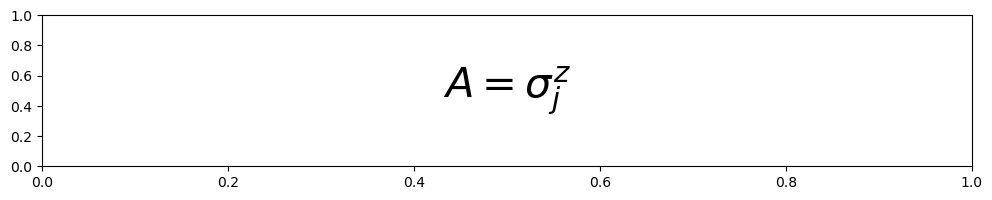

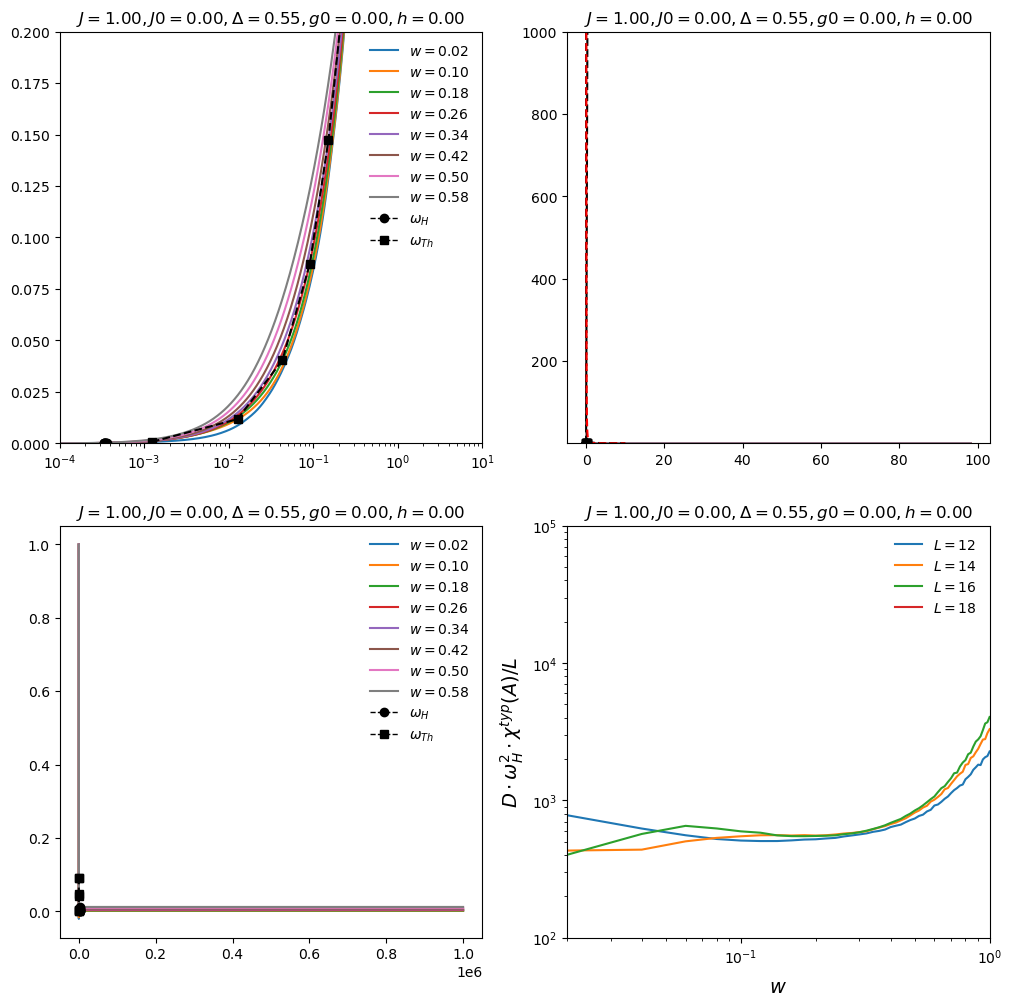

In [1536]:
use_derivative = 1
from matplotlib.lines import Line2D
def add_legend(axis):
    legend = axis.legend()
    #ax = legend.axes

    handles, labels = axis.get_legend_handles_labels()
    handles.append(Line2D([0], [0], linewidth=1, linestyle='--', marker='o', color='black'))
    handles.append(Line2D([0], [0], linewidth=1, linestyle='--', marker='s', color='black'))
    labels.append(r"$\omega_H$")
    labels.append(r"$\omega_{Th}$")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
    axis.legend(handles, labels, frameon=False, loc='best', fontsize=10)

time_dir = cf.base_directory + "timeEvolution%s"%kPSep + cf.subdir
int_dir = cf.base_directory + "IntegratedResponseFunction%s"%kPSep + cf.subdir
spec_dir = cf.base_directory + ("IntegratedResponseFunction%sDERIVATIVE%s"%(kPSep,kPSep) if use_derivative else "ResponseFunction%s"%kPSep) + cf.subdir
agp_dir = cf.base_directory + "AGP{kPSep}" + cf.op_name + kPSep;

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(12,2), dpi = 100)
axis.annotate(r"$A=$"+cf.operator_formuals[user_settings['operator']], xy=(0.5, 0.5), color='black', size=30, ha='center', va='center')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( nrows=2, ncols=2, figsize=(12,12), dpi = 100)

func = lambda y, x: y

#---------------------- TIME EVOLUTION
plot_spectral(axis = ax3, dir = time_dir, settings=user_settings, xlab="t", ylab="\\langle A(t)A\\rangle", yscale='linear', normalise=False)
add_legend(axis=ax3)

#---------------------- INTEGRATED SPECTRAL FUNCTION
plot_spectral(axis = ax1, dir = int_dir, settings=user_settings, xlab="\\omega", ylab="I_A(\\omega)", yscale='linear', normalise=True, func_x=func)
add_legend(axis=ax1)
ax1.set_ylim(0,0.2)
#---------------------- SPECTRAL FUNCTION
plot_spectral(axis = ax2, dir = spec_dir, settings=user_settings, xlab="\\omega / \\Delta^2", ylab="S_A(\\omega)", yscale='log', func_x = func)
ax2.set_ylim(5e-4, 1e3)
xval=np.logspace(-6,1,100)
ax2.plot(xval, 3e3*xval, linestyle='--', color='black')
ax2.plot(xval, 3e0/xval, linestyle='--', color='black')
ax2.plot(xval, 3e0/xval**2, linestyle='--', color='red')
# Thouless energy
new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_vs(cf.plot_settings.settings['scaling'])
new_set_class.set_scaling("L")
tau_data = thouless.load(getattr(new_set_class, 'settings'))
idx = list(tau_data[0]).index(cf.L)
tausfull = list(tau_data[2][idx])
vars_from_tau = list(tau_data[1][idx])
vals = get_scaling_array(settings=user_settings)
taus = []
taus2 = []
spec_at_tau = []
int_at_tau = []
time_at_tau = []
for i in range(0, len(vals)):
    x = vals[i]
    xdata = ax2.lines[i].get_xdata()
    ydata = ax2.lines[i].get_ydata()
    idx = min(range(len(vars_from_tau)), key=lambda i: abs(vars_from_tau[i] - x));    tau_tmp = func(1. / tausfull[idx], x);    taus.append(tau_tmp);    
    tau_tmp2 = 1. / tausfull[idx];  taus2.append(tau_tmp2);
    idx = min(range(len(xdata)), key=lambda i: abs(xdata[i] - tau_tmp));    spec_at_tau.append(ydata[idx])
    xdata_int = ax1.lines[i].get_xdata()
    ydata_int = ax1.lines[i].get_ydata()
    idx = min(range(len(xdata_int)), key=lambda i: abs(xdata_int[i] - tau_tmp2));    int_at_tau.append(ydata_int[idx])
    xdata_time = ax3.lines[i].get_xdata()
    ydata_time = ax3.lines[i].get_ydata()
    idx = min(range(len(xdata_time)), key=lambda i: abs(xdata_time[i] - 1. / tau_tmp2));    time_at_tau.append(ydata_time[idx])
taus = np.array(taus)
taus2 = np.array(taus2)
ax2.plot(taus, spec_at_tau, linestyle='--', marker='s', color='black')
ax1.plot(taus2, int_at_tau, linestyle='--', marker='s', color='black')
ax3.plot(1. / taus2, time_at_tau, linestyle='--', marker='s', color='black')

#---------------------- ADIABATICS
new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_vs(cf.plot_settings.settings['scaling'])
new_set_class.set_scaling("L")
new_set_class.set_scales(xscale='log', yscale='log')
plot_agp(axis = ax4, settings_class=new_set_class, which=2)
ax4.set_ylim(1e2, 1e5)
ax1.set_xlim(1e-4, 1e1)
ax1.set_xscale('log')